[Kaggleのtitanic問題で上位10%に入るまでのデータ解析と所感 - mirandora.commirandora.com](https://www.mirandora.com/?p=1804)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from decimal import Decimal, ROUND_HALF_UP
from collections import Counter

## 参加者の予測精度

In [2]:
df_participants = pd.read_csv('../data/titanic-publicleaderboard.csv')
df_participants.head()

,TeamId,TeamName,SubmissionDate,Score
0,31750,statIsFun,2012-12-28 06:31:01,0.76076
1,31782,98074,2012-12-28 20:39:54,0.00000
2,31750,statIsFun,2013-02-06 19:02:52,0.77511
3,34352,odedha,2013-02-09 20:37:12,0.76555
4,34454,Raghavendra Rao,2013-02-11 17:35:40,0.77033


In [3]:
df_participants['Score'].describe()

count    47099.000000
mean         0.749839
std          0.099161
min          0.000000
25%          0.760760
50%          0.770330
75%          0.779900
max          1.000000
Name: Score, dtype: float64

In [4]:
total_count = df_participants['Score'].count()
partial_count = df_participants[(0.6 < df_participants['Score']) & (df_participants['Score'] < 0.8)]['Score'].count()
print(partial_count/total_count)

0.910698740949914


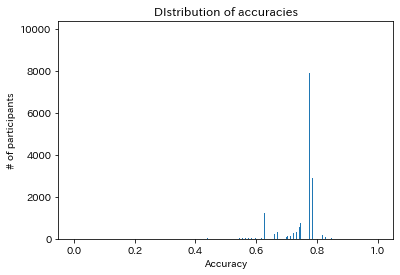

In [5]:
decile = lambda num: Decimal(num).quantize(Decimal('.001'), rounding=ROUND_HALF_UP)
histogram = Counter(decile(score) for score in df_participants['Score'])
plt.bar(
  [float(x) for x in histogram.keys()],
  histogram.values(),
  0.001
)
plt.title('DIstribution of accuracies')
plt.xlabel('Accuracy')
plt.ylabel('# of participants')
plt.show()

- 2020/06/07 時点で、参加者数は 47,099 人、平均予測精度は 0.749。
- 参加者の 91% が、予測精度 0.6 ～ 0.8。

## データ探索

In [6]:
df_train = pd.read_csv('../data/train.csv')
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
df_train['Sex'].describe()

count      891
unique       2
top       male
freq       577
Name: Sex, dtype: object

In [8]:
df_train['Embarked'].describe()

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

`unique`の結果から、Sex(性別)、Embarked(乗船場所)はデータの種類が限られているため、ダミー変数化しておく。

In [9]:
df_train['Sex'] = df_train['Sex'].map({'female': 0, 'male': 1})
df_train = df_train.rename(columns={'Sex': 'Male'})
df_train['Embarked'] = df_train['Embarked'].map({'C': 1, 'Q': 2, 'S': 3})
df_train.head()

,PassengerId,Survived,Pclass,Name,Male,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,3.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,1.0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,3.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,3.0
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,3.0


In [10]:
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Male             0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Cabin (客室) は欠損値が多いので除外してもよさそう。  
Cabin に次いで、Age (年齢) の欠損値が多い。  
Cabin とカテゴリ化されていないデータ(PassengerId、Name、Ticket)を除外し、Survived との相関を見る。

<AxesSubplot:>

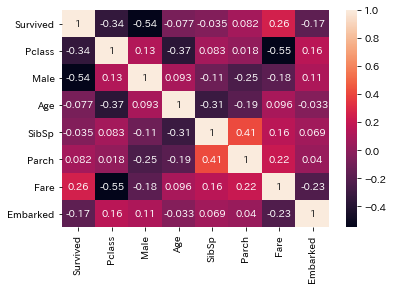

In [13]:
df_train = df_train.drop('PassengerId', axis='columns')
df_train = df_train.drop('Name', axis='columns')
df_train = df_train.drop('Ticket', axis='columns')
df_train = df_train.drop('Cabin', axis='columns')

# df_train_dn.corr()
# sns.heatmap(df_train_dn)
sns.heatmap(df_train.corr(), annot=True)

Male (性別) が最も相関が高く、次いで Age (年齢) が高い。
Age は欠損値が多いので、Age を推計できれば、予測精度が上がりそう。

性別と年齢ごとの生死を可視化してみる。
（x軸が年齢、y軸が性別(0=女、1=男)。赤色が生存、青色が死亡。）

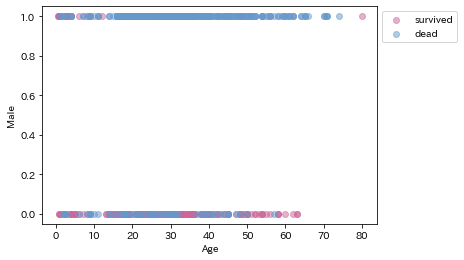

In [14]:
df_train_survived = df_train[df_train.Survived == 1]
df_train_survived_age = df_train_survived.iloc[:, 3]
df_train_survived_male = df_train_survived.iloc[:, 2]
plt.scatter(
  df_train_survived_age,
  df_train_survived_male,
  color="#cc6699",
  alpha=0.5,
  label="survived"
)

df_train_dead = df_train[df_train.Survived == 0]
df_train_dead_age = df_train_dead.iloc[:, 3]
df_train_dead_male = df_train_dead.iloc[:, 2]
plt.scatter(
  df_train_dead_age,
  df_train_dead_male,
  color="#6699cc",
  alpha=0.5,
  label="dead",
)
plt.xlabel('Age')
plt.ylabel('Male')
plt.legend(bbox_to_anchor=(1,1))
plt.show()